# Goal: Diagnose and Tune Sluggish PID Controller

### In this notebook I use some process controls theory to diagnose and tune a PID controller in an industrial facility. The original issue arised from noticing that the controller was unusually sluggish.

The first main goal we are trying to achieve is an accurate simulation of the system. Ideally this can be done using first order process models as they are very well known. Because it is a real process, we have plenty of data and examples to which we can compare, so we know what the model results *should* look like.

In the following module we set up the transfer function, calculate its steady state error to a step input, and generate the Bode plot:


Open Loop Transfer Function (Gol): 
   1.31
----------
0.25 s + 1


Open loop low freq gain: 1.31 (this is 2.35 dB on the Bode plot, the steady state gain)

Close the loop to get the steady state error for unit step: 0.4329004329004329 %

or, ( 1-0.4329004329004329 )*(PV Span/OP Span) = 3.4025974025974026 gpm


Bode Plot:


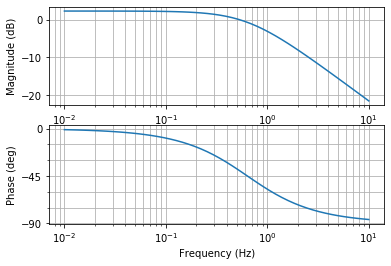

In [203]:
#Module goal: set up initial system bode plot (model dynamics of the PID loop as-is)

import pylab
import math as m
import numpy as np
import control as ctr
import control.matlab as ml
import matplotlib.pyplot as plt
from IPython.display import display

#plant - lumped model - process, actuator, and sensor
#Transfer function for open loop feedback system:
Gp1 = 1.31             #estimated process gain
Tau1 = 15/60           #estimated process lag  (minutes [15 sec])
num = Gp1
den = np.polymul(np.array([Tau1,1]), np.array(1))
Gol = ml.tf(num, den)  #s-domain model of an FOP

print(f"\nOpen Loop Transfer Function (Gol): {Gol}")
gain, phase, w = ml.bode(Gol)

dcg = ml.dcgain(Gol)  #This appears to give gain in magnitude instead of dB, but dB are shown on Bode plot
SSE = 1/(1 + dcg)     #for a unit step this should mean either the response to a valve change of 1% span OP (valve) or
                      #the response IF we were to close the loop and use a P controller w Kp=1 and do a SP change of 1% PV
GPM = (1-SSE)*600/100
print(f"\nOpen loop low freq gain: {dcg} (this is 2.35 dB on the Bode plot, the steady state gain)")
print(f"\nClose the loop to get the steady state error for unit step: {SSE} %")    
print(f"\nor, ( 1-{SSE} )*(PV Span/OP Span) = {GPM} gpm\n\n")
print('Bode Plot:')

Everything looks as expected. The 3.4 gpm increment info could be used to increase condfidence in the model by creating a valve curve from the data historian and checking the slope. If the valve curve is nonlinear, then check the slope of the linear region of the curve.

In the next module we close the loop and generate a time domain response to a unit step:

Our system:
 
      0.3275 s + 1.31
----------------------------
0.0625 s^2 + 0.8275 s + 2.31
 
Type: Second order process (1 zero, 2 poles)

Note that the plots level out at (1 - the DC gain)


A 1.1 valve change results in a gpm change of:


3.4025974025974026

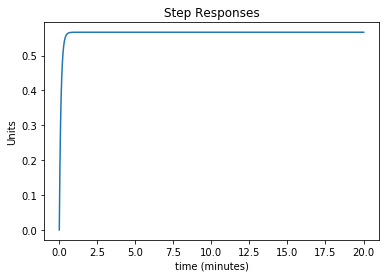

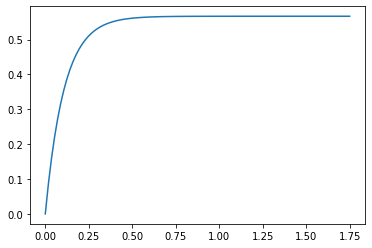

In [224]:
#Module goal: create closed loop version. Simulate response to step change input of 1%:

Gcl = Gol / (1+ Gol)
Gcl

print(f"Our system:\n {Gcl} \nType: Second order process (1 zero, 2 poles)")

T = np.arange(0,20.01, .01) 
t, y = ctr.step_response(Gcl, T=T,X0=0)
ym, tm = ml.step(Gcl)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set_title("Step Responses")
ax.set_xlabel("time (minutes)")
ax.set_ylabel("Units")

fig, ax = plt.subplots()
ax.plot(tm, ym)
#ax.set_ylim(0,0.5)

print(f"\nNote that the plots level out at (1 - the DC gain)")
print("\n\nA 1.1 valve change results in a gpm change of:")
(1-SSE)*600/100


We see, above, that our system naturally responds very quickly. Adding the PI controller should produce the undeireably slow (current) system.

PID Controller: 
0.2 s + 0.2
-----------
     s

Plant w PID: 
0.262 s + 0.262
---------------
  0.25 s^2 + s


Gain Margin: inf
(Critical Frequency: nan) 

Phase Margin: 101.2799732118034 
(Crossover Frequency: 0.2708178659408095)


 System Bode Plot:


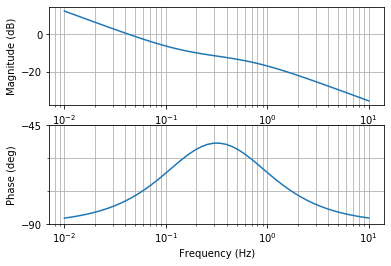

In [206]:
#Module goal: add a PI controller onto our system. set up for a step test.
#After this point we should have a fairly accurate model of this subsystem of the plant
#Non-interactive PI Controller with Kc = .2 Ki = 1 min:
Kc = 0.2
Ti = 1
PIDc1 = ml.tf(np.array([Kc*Ti, Kc]),np.array([Ti, 0]))
print(f"PID Controller: {PIDc1}")

GolConcs1 = Gol*PIDc1
print(f"Plant w PID: {GolConcs1}")

gain, phase, w = ml.bode(GolConcs1)
gm, pm, wcg, wcp = ml.margin(GolConcs1)
print(f"\nGain Margin: {gm}\n(Critical Frequency: {wcg}) \n\nPhase Margin: {pm} \n(Crossover Frequency: {wcp})")
print("\n\n System Bode Plot:")

As mentioned in the code module above, the plant DCS presently uses a non-interactive algorithm with the specified tuning parameters to control the process. Next up is the step test: 

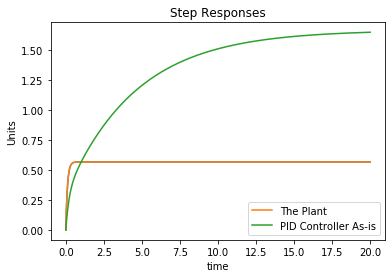

In [208]:
#Close the loop and simulate unit step input
GclConcs1 = GolConcs1/ (1 + GolConcs1)
y4, t4 = ml.step(GclConcs1*1.6666667, T, 0)
fig, ax = plt.subplots()


ax.plot(t, y)  
ax.set_title("Step Responses")
ax.set_xlabel("time")
ax.set_ylabel("Units")


plt.plot(t,y, label="The Plant")               #Original system - the plant
plt.plot(t4,y4, label='PID Controller As-is')  #Our final system w PI controller
plt.legend()
plt.show()
plt.close()

So the PID controller is slowing the system down quite a bit, but not to the extent that we observe in the field. What else could be slowing it down?

Plantx: 
    0.5
-----------
1.667 s + 1

PIDx Controller: 
0.2 s + 0.2
-----------
     s

Plant w PIDx: 
 0.1 s + 0.1
-------------
1.667 s^2 + s


Gain Margin: inf
(Critical Frequency: nan) 

Phase Margin: 86.2791928437345 
(Crossover Frequency: 0.09914580798363593)


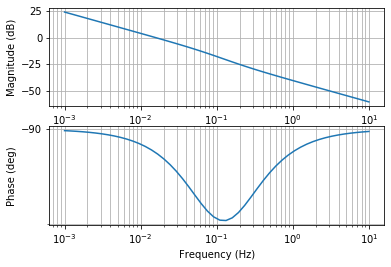

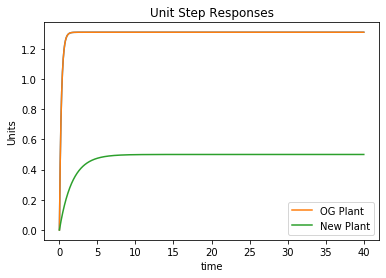

You can see how drastically the gain was decreased and the longer lag time. Let's see if the PID system now accurately models that of the field: 


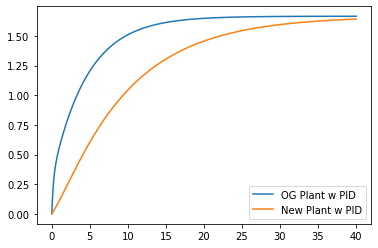

I'm pretty sure I was not off in my original estimate of the gain by a factor of 2. However, even if I was, the system still gives a response that is a bit different from that observed in the field. Specifically, this present system is too linear in the first 10 minutes. If inaccurate plant parameters might not be at fault....maybe there is some sort of processing done to the signal. Let's model the effect of a filter in the next cell.


In [212]:
#Module goal: play with parameters to estimate system


#test inaccurate process gain and lag estimates:
num = .5     #new plant gain
den = np.polymul(np.array([100/60,1]), np.array(1))
Golx = ml.tf(num, den)
print(f"Plantx: {Golx}")
PIDc1x = ml.tf(np.array([Kc*Ti,Kc]),np.array([Ti, 0]));
print(f"PIDx Controller: {PIDc1x}")
GolConcs1x = Golx*PIDc1x
print(f"Plant w PIDx: {GolConcs1x}")
gainx, phasex, wx = ml.bode(GolConcs1x);

gmx, pmx, wcgx, wcpx = ml.margin(GolConcs1x)
print(f"\nGain Margin: {gmx}\n(Critical Frequency: {wcgx}) \n\nPhase Margin: {pmx} \n(Crossover Frequency: {wcpx})")


#Step response from original plant
ta1, ya1 = ctr.step_response(Gol, T=T*2,X0=0)
fig, ax = plt.subplots()

#Step response from new plant
ta2, ya2 = ctr.step_response(Golx, T=T*2,X0=0)
#fig, ax = plt.subplots()


#Close loop and simulate unit step input (since its closed I believe this is a SP change)
GclConcs1x = GolConcs1x/ (1 + GolConcs1x)
ya3, ta3 = ml.step(GclConcs1x*1.6666667, T*2, 0)

#OG Closed loop step input
GclConcs1 = GolConcs1/ (1 + GolConcs1)
ya4, ta4 = ml.step(GclConcs1*1.6666667, T*2, 0)


ax.plot(ta1, ya1)  
ax.set_title("Unit Step Responses")
ax.set_xlabel("time")
ax.set_ylabel("Units")

plt.plot(ta1,ya1, label="OG Plant")    #Original system - the plant
plt.plot(ta2,ya2, label='New Plant')  
plt.legend();

plt.show()
plt.close()

print("You can see how drastically the gain was decreased and the longer lag time. Let's see if the PID system now accurately models that of the field: ")


ax.plot(ta4, ya4)  
ax.set_title("Closed Loop Responses")
ax.set_xlabel("time")
ax.set_ylabel("Units")

plt.plot(ta4,ya4, label="OG Plant w PID")    #Original system - the plant
plt.plot(ta3,ya3, label='New Plant w PID')  #Our final system w PI controller
plt.legend();

plt.show()
plt.close()

print("I'm pretty sure I was not off in my original estimate of the gain by a factor of 2. However, even if I was, the system still gives a response that is a bit different from that observed in the field. Specifically, this present system is too linear in the first 10 minutes. If inaccurate plant parameters might not be at fault....maybe there is some sort of processing done to the signal. Let's model the effect of a filter in the next cell.")

FoF 3 minutes:
   1
-------
3 s + 1



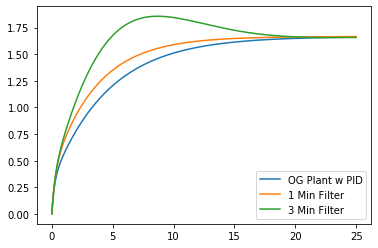

In [225]:
#Module goal: see what the system looks like with a heavy filter on it
Tx = np.arange(0,25.01, .01) 

DCS_filter1 = ml.tf(1,np.polymul(np.array([1,1]),np.array(1)))
DCS_filter3 = ml.tf(1, np.polymul(np.array([3,1]), np.array(1)))
print(f"FoF 3 minutes:{DCS_filter3}")


#Close loop and simulate unit step input
GclConcs1 = GolConcs1/ (1 + GolConcs1*(DCS_filter1)) #1 min filter
yb1, tb1 = ml.step(GclConcs1*1.6666667, Tx, 0)
GclConcs1 = GolConcs1/ (1 + GolConcs1*(DCS_filter5)) #5 min filter
yb2, tb2 = ml.step(GclConcs1*1.6666667, Tx, 0)

#OG Closed loop step input
GclConcs1 = GolConcs1/ (1 + GolConcs1)
ya4, ta4 = ml.step(GclConcs1*1.6666667, Tx, 0)




#####Plot OG PID, OG PID 1 min filter, OG PID 5 min filter
ax.plot(ta4, ya4)  
ax.set_title("Impact of Filters")
ax.set_xlabel("time")
ax.set_ylabel("Units")

plt.plot(ta4,ya4, label="OG Plant w PID")    #Original system 
plt.plot(tb1,yb1, label='1 Min Filter')  #
plt.plot(tb2,yb2, label='3 Min Filter')  #
plt.legend();
plt.show()

#aha!

#plt.close()
#ax.plot(ta1, ya1)  
#ax.set_title("Unit Step Responses")
#ax.set_xlabel("time")
#ax.set_ylabel("Units")

#plt.plot(ta1,ya1, label="OG Plant")    #Original system - the plant
#plt.plot(ta2,ya2, label='New Plant')  
#plt.legend();

#plt.show()
#plt.close()

Now this actually models the observed system in the field pretty closely. The 1 minute filter signal matches the dynamics routinely observed in the historian. I can't imagine why there would be a 3 min filter on this sort of control loop (flow controller), but we were just experimenting

That being said, we can now feel very comfortable going to the client and not only saying that there seems to be an unreasonably sluggish controller, but also raising two precise, possible issues to investigate (the tuning parameters and the presence of a large filter). However, we'd be remiss to not come with estimates of optimal tuning constants...

Lumped Model of Plant: 
   1.31
----------
0.25 s + 1

Tuned PID Controller: 
0.06361 s + 0.2545
------------------
      0.25 s

Plant w PID: 
        0.08333 s + 0.3333
-----------------------------------
0.005208 s^3 + 0.08333 s^2 + 0.25 s


Gain Margin: inf
(Critical Frequency: nan) 

Phase Margin: 83.69781427986959 
(Crossover Frequency: 1.3252756914480468)


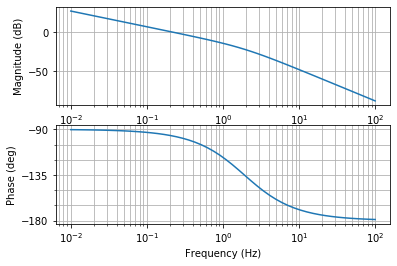

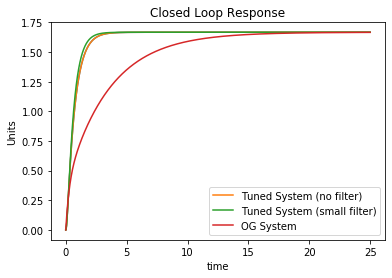



Good stuff! We see the addition of a low pass filter (LPF) does slow the response just a little bit, but the noise cancellation and higher Kc that it allows is typically worth it. Also, we were able to dramatically reduce the speed of SP changes and increase the system's ability to reject disturbances. This was all while still maintaining a healthy level of robustness (lambda factor of 3). The stability can be confirmed / further evaluated through bode plots, root locus plots, and more. Some of these tools will be created in the cells to follow.

For clarity's sake, the final parameters used were:

Lambda Tuning Factor: 3 
Kc: 0.2544529262086514 %/% 
Ti 0.25 minutes  
LPF: 0.08333333333333333 minutes


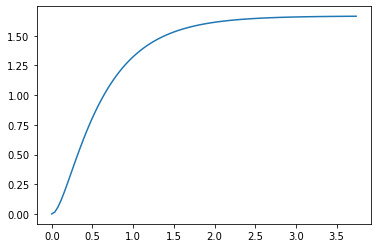

In [226]:
#Module goal: follow simple lambda tuning rules to generate constants which optimize the balance of disturbance rejection vs robustness

##Calculate tuning parameters: 
l_factor = 3  #medium aggression
lambdaa = l_factor*Tau1
tuned_tau = Tau1
tuned_gain = tuned_tau / (lambdaa*Gp1)



################################
###########Tuned-up PID#########
################################

num = Gp1
den = np.polymul(np.array([Tau1,1]), np.array(1))
Golx = ml.tf(num, den)
print(f"Lumped Model of Plant: {Golx}")
Kc = tuned_gain
Ti = tuned_tau
PID_tuned = ml.tf(np.array([Kc*Ti, Kc]),np.array([Ti, 0]))
filter_time_constant = 1/12
DCS_filter = ml.tf(1,np.polymul(np.array([filter_time_constant,1]),np.array(1)))
GclConcs_filt = GolConcs_tuned/ (1 + GolConcs_tuned*(DCS_filter)) #1 min filter

print(f"Tuned PID Controller: {PID_tuned}")
GolConcs_tuned = Golx*PID_tuned*DCS_filter
print(f"Plant w PID: {GolConcs_tuned}")
gainx, phasex, wx = ml.bode(Golx*PID_tuned*DCS_filter)
gmx, pmx, wcgx, wcpx = ml.margin(Golx*PID_tuned*DCS_filter)
print(f"\nGain Margin: {gmx}\n(Critical Frequency: {wcgx}) \n\nPhase Margin: {pmx} \n(Crossover Frequency: {wcpx})")

#Close loop and simulate unit step input
GclConcs_tuned = GolConcs_tuned/ (1 + GolConcs_tuned)
yx, tx = ml.step(GclConcs_tuned*1.6666667, Tx, 0)
fig, ax = plt.subplots()


#With filter
filter_time_constant = 1/12
DCS_filter = ml.tf(1,np.polymul(np.array([filter_time_constant,1]),np.array(1)))
GclConcs_filt = GolConcs_tuned/ (1 + GolConcs_tuned*(DCS_filter)) #1 min filter
yx1, tx1 = ml.step(GclConcs_filt*1.6666667, Tx, 0)


ax.plot(tx, yx)  
ax.set_title("Closed Loop Response")
ax.set_xlabel("time")
ax.set_ylabel("Units")

plt.plot(tx,yx, label='Tuned System (no filter)')   #Our final system w PI controller
plt.plot(tx1,yx1, label='Tuned System (small filter)') 
plt.plot(tb1,yb1, label='OG System') #Final model of the original system - the plant w 1 min filter
plt.legend();

plt.show()
print("\n\nGood stuff! We see the addition of a low pass filter (LPF) does slow the response just a little bit, but the noise cancellation and higher Kc that it allows is typically worth it. Also, we were able to dramatically reduce the speed of SP changes and increase the system's ability to reject disturbances. This was all while still maintaining a healthy level of robustness (lambda factor of 3). The stability can be confirmed / further evaluated through bode plots, root locus plots, and more. Some of these tools will be created in the cells to follow.\n\nFor clarity's sake, the final parameters used were:")
print(f"\nLambda Tuning Factor: {l_factor} \nKc: {Kc} %/% \nTi {tuned_tau} minutes  \nLPF: {filter_time_constant} minutes")
plt.close()


zoomy, zoomt = ml.step(GclConcs_filt*1.6666667)
ax.plot(zoomt, zoomy)  
ax.set_title("Closed Loop Response")
ax.set_xlabel("time (minutes)")
ax.set_ylabel("Units")
plt.plot(zoomt, zoomy)
plt.show()
plt.close()

In [ ]:
#Close loop and simulate sine wave input (since its closed I believe this is a continuous SP change)
#GclConcs1 = GolConcs1/ (1 + GolConcs1)

u=[0]
for t in T:
    u.append(m.sin(t*5)*.5)
    
u = np.asarray(u[1:])
y5, t5, you = ml.lsim(GclConcs1,u, T*100)
fig, ax = plt.subplots()

#y5 is 1 column vector
#t5 is 1 column vector, time
#you is 3 column matrix containing...??, the response, and the input?
print(you[:,0])
#ax.plot(t5, y5)   
ax.set_title("Closed Loop Responses")
ax.set_xlabel("time")
ax.set_ylabel("Units")

#plt.plot(t5,y5, label="y5")    #Original system - the plant
plt.plot(t5,you[:,0], label="??") #"you" is a 3 column matrix with the response (y5), 
plt.plot(t5,you[:,1], label="Response?")
plt.plot(t5,you[:,2], label="Input signal")

plt.legend()

Poles of the System As-is:

[-10.47213595+0.00000000e+00j  -4.        +1.69051857e-07j
  -4.        -1.69051857e-07j  -1.52786405+0.00000000e+00j
   0.        +0.00000000e+00j]


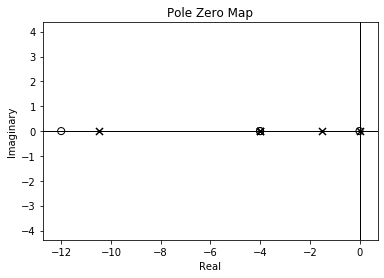

In [221]:
print("Poles of the System As-is:\n")
print(ml.pole(GclConcs_filt)) #gives values of all poles 

ml.pzmap(GclConcs_filt); #crazy...#x's are poles
                     #which is the dominant pole??? usually people do a step response to see.
                     #Real negative pole - decaying exponential
                     #pair of imaginary poles - oscillations (if in the LH plane then decaying)
                     #(0,0) - integrator
                     #all poles are real & negative => slowest exponential (closest to the origin) dominates response time
                     #here, I believe that is -1.53, which gives time constant of 1/1.53 = 39.2 sec, which was observed above
                     #(for system w tuned PI controller and small filter on it)
                    
                    

Sensitivity and Complementary Sensitivity Functions:
(sensitivity in blue, complementary sensitivity in orange)


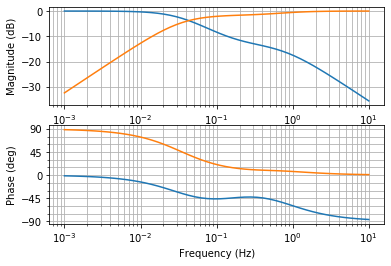

In [194]:
################################
##########Sensitivities#########
################################


#design tool
#OG system
comp_T = Golx*PIDc1 / (1 + Golx*PIDc1)
sens = 1 / ( 1 + Golx*PIDc1)
print("Sensitivity and Complementary Sensitivity Functions:")
ml.bode(comp_T);
ml.bode(sens);

print("(sensitivity in blue, complementary sensitivity in orange)")

##########ML Syntax#########

#loops = ctr.getCompSensitivity(Golx, PIDc1x) #Not yet available



Sensitivity and Complementary Sensitivity Functions:
(sensitivity in blue, complementary sensitivity in orange)


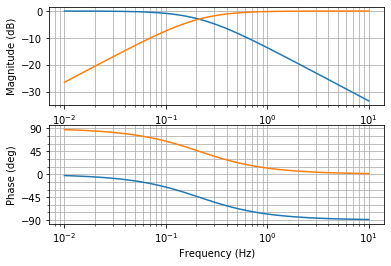

In [195]:
comp_T = Golx*PID_tuned / (1 + Golx*PID_tuned)
sens = 1 / ( 1 + Golx*PID_tuned)
print("Sensitivity and Complementary Sensitivity Functions:")
ml.bode(comp_T);
ml.bode(sens);

print("(sensitivity in blue, complementary sensitivity in orange)")

#we successfully moved up the crossover frequency, speeding up the system

Root Locus Plot of As-Is System:


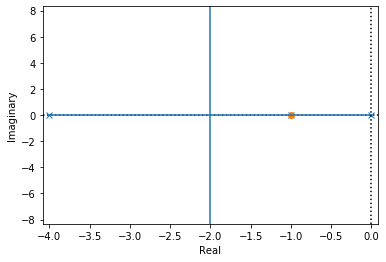

In [199]:
################################
##########Root Locus############
################################

#stability tool, rudimentary design tool
print("Root Locus Plot of As-Is System:")

ml.rlocus(Gol*PIDc1*DCS_filter1);

#poles = x's. Starts here, goes to the zeros as the Kc is increased

Root Locus Plot of Tuned System:


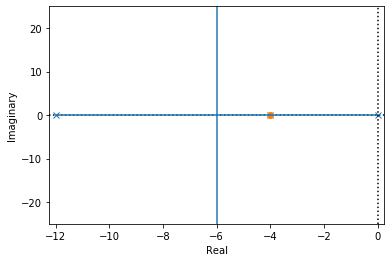

In [178]:
#RL of updated system

print("Root Locus Plot of Tuned System:")
ml.rlocus(Golx*PID_tuned*DCS_filter);

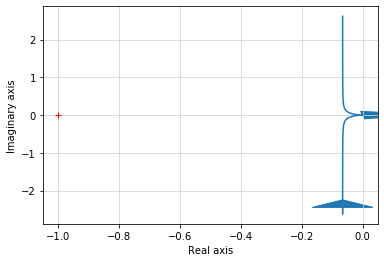

In [182]:
################################
########## Nyquist #############
################################

#stability tool
real, imag, freq = ctr.nyquist_plot(Gol*PIDc1*DCS_filter1) #use open loop transfer fxn

Not the most beautiful representation.... but we see that -1 does not get encircled. Adding a deadtime term to the model would give the more familiar cardiod / sprial shape. The Nyquist plot of the tuned system is below:

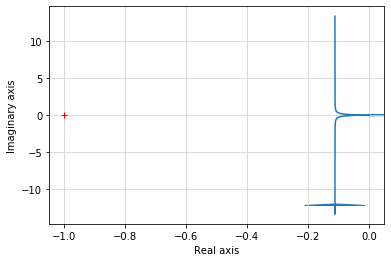

In [183]:
#New Nyquist
real, imag, freq = ctr.nyquist_plot(Golx*PID_tuned*DCS_filter) #use open loop transfer fxn

SISO Plots of Tuned System:


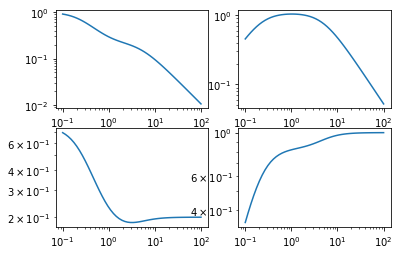

In [222]:
################################
###########S I S O #############
################################

#design tool
print("SISO Plots of Tuned System:")
ml.gangof4(Gol, PIDc1);

(T , PS ; CS , S)

(top left is T, the complementary sensitivity function; top right is PS / load disturbance)

SISO Plots of Tuned System:


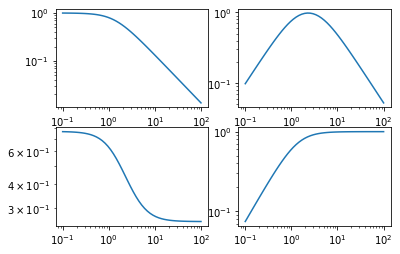

In [227]:
print("SISO Plots of Tuned System:")
ml.gangof4(Golx, PID_tuned);



Wow those were a bit more different than I was anticipating. In T, do see the worse ability of the system to reject "noise," but really the level of noise rejection in the OG system was very much overkill. 

We also see (in T) a massive gain in the ability to SP track as its plot is actually flat at the lower frequencies

In S, we see an increase in the ability to reject disturbances in the middle frequencies, which in this case happened to be important for the real process. This is also reflected in PS.

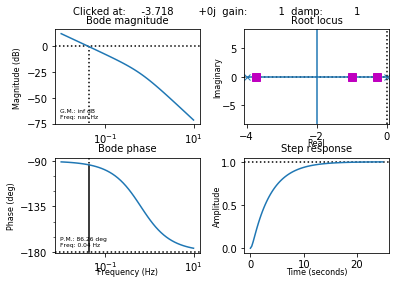

In [201]:
ctr.sisotool(Gol*PIDc1*DCS_filter1) #pretty neat man

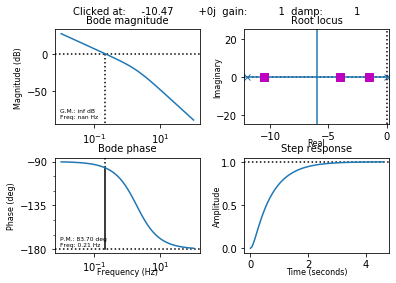

In [202]:
ctr.sisotool(Golx*PID_tuned*DCS_filter) #note the step resposne, root loci